In [1]:
from datasets import load_dataset
#load the mnist dataset from HuggingFace datasets and convert the format to "torch"
dataset = load_dataset("ylecun/mnist").with_format("torch")

#split the training and testing datasets
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import default_collate, RandomSampler, SequentialSampler

torch.manual_seed(42)

#defining samplers
# Since datasets is a Map-style dataset, we can setup a sampler to shuffle the data
train_sampler = RandomSampler(train_dataset)
test_sampler = RandomSampler(test_dataset)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

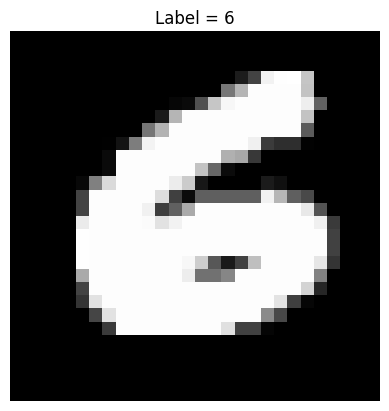

In [3]:
#Let's display one image and the corresponding label
import matplotlib.pyplot as plt

random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
img, label = train_dataset["image"][random_idx], train_dataset["label"][random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Label = {label.item()}")
plt.axis("Off")

In [4]:
# Now we can set up some torchdata.nodes to create our pre-proc pipeline
from torchdata.nodes import MapStyleWrapper, ParallelMapper, Batcher, PinMemory, Loader

# All torchdata.nodes.BaseNode implementations are Iterators.
# MapStyleWrapper creates an Iterator that combines sampler and train_dataset to create an iterator.
#
# Under the hood, MapStyleWrapper just does:
# > node = IterableWrapper(sampler)
# > node = Mapper(node, map_fn=train_dataset.__getitem__)  # You can parallelize this with ParallelMapper

node = MapStyleWrapper(map_dataset=train_dataset, sampler=train_sampler)

# Now we want to transform the raw inputs. We can just use another Mapper with
# a custom map_fn to perform this. Using ParallelMapper allows us to use multiple
# threads (or processes) to parallelize this work and have it run in the background
#We need a mapper function to convert a dtype and also normalize
def map_fn(item):
    image = item["image"].to(torch.float32)/255
    label = item["label"]

    return {"image":image, "label":label}
node = ParallelMapper(node, map_fn=map_fn, num_workers=2) # output items are Dict[str, tensor]


# Hyperparameters
batch_size = 2 #batch size is kept low so that we can easily see the bacthes when we print them in the later cells

# Next we batch the inputs, and then apply a collate_fn with another Mapper
# to stack the tensors between. We use torch.utils.data.default_collate for this
node = Batcher(node, batch_size=batch_size) # output items are List[Dict[str, tensor]]
node = ParallelMapper(node, map_fn=default_collate, num_workers=2) # outputs are Dict[str, tensor]

# we can optionally apply pin_memory to the batches
if torch.cuda.is_available():
    node = PinMemory(node)

# Since nodes are iterators, they need to be manually .reset() between epochs.
# We can wrap the root node in Loader to convert it to a more conventional Iterable.
train_loader = Loader(node)

#Similar process can be followed to ger test and validation loaders

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), 'label': tensor([3, 4])}
There are 2 samples in this batch


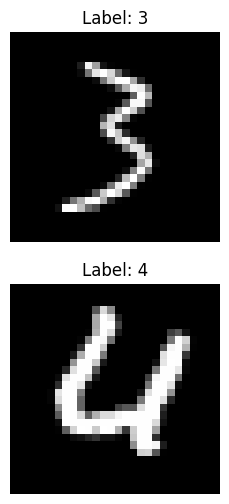

In [5]:
# Once we have the train_loader, we can get batches from it over multiple epochs, to train the ML model
# Let us look at one batch 
fig, axs = plt.subplots(2, figsize=(8, 6))

for batch in train_loader:
    print(batch)
    print(f"There are {len(batch)} samples in this batch")

    # Since we used default_collate, each batch is a dictionary, with two keys: "image" and "label"
    # The value of key "image" is a stacked tensor of images in the batch
    # Similarly, the value of key "label" is a stacked tensor of labels in the batch
    images = batch["image"]
    labels = batch["label"]

    #let's also display the two item
    for i in range(len(images)):
        axs[i].imshow(images[i].squeeze(), cmap='gray')
        axs[i].set_title(f"Label: {labels[i]}")   
        axs[i].set_axis_off()

    break